In [15]:
import torch
import matplotlib.pyplot as plt
import torch.nn.functional as F
import random

In [16]:
words = open('names.txt', 'r').read().splitlines()
chars = sorted(list(set(''.join(words))))
stoi = {s:i+1 for i,s in enumerate(chars)}
stoi['.'] = 0
itos = {s:i for i,s in stoi.items()}
vocab_size = len(stoi)

In [17]:
# creating the dataset
block_size = 8

def build_dataset(words):
    X, Y = [], []
    for w in words:
        context = [0] * block_size
        for ch in w+'.':
            X.append(context)
            Y.append(stoi[ch])
            context = context[1:] + [stoi[ch]]
    X = torch.tensor(X)
    Y = torch.tensor(Y)
    return X, Y

# creating the test/train/validation sets
random.seed(42)
random.shuffle(words)
n1 = int(0.8 * len(words))
n2 = int(0.9 * len(words))

X_train, Y_train = build_dataset(words[:n1]) # 80% of the data
X_test, Y_test = build_dataset(words[n1:n2]) # 10% of the data
X_dev, Y_dev = build_dataset(words[n2:]) # 10% of the data

print('X_train.shape -->', X_train.shape, 'Y_train.shape -->', Y_train.shape)
print('X_test.shape -->', X_test.shape, 'Y_test.shape -->', Y_test.shape)
print('X_dev.shape -->', X_dev.shape, 'Y_dev.shape -->', Y_dev.shape)

X_train.shape --> torch.Size([182625, 8]) Y_train.shape --> torch.Size([182625])
X_test.shape --> torch.Size([22655, 8]) Y_test.shape --> torch.Size([22655])
X_dev.shape --> torch.Size([22866, 8]) Y_dev.shape --> torch.Size([22866])


In [18]:
# Class Definition for Linear, BatchNorm and Tanh layers, made to look like pytorch's
from typing import Any


class Linear:
    def __init__(self, n_in, n_out, bias=True):
        self.weights = torch.randn(n_in, n_out) / (n_in ** 0.5)
        self.bias = torch.zeros(n_out) if bias else None

    def __call__(self, x):
        self.out = x @ self.weights
        if self.bias is not None:
            self.out += self.bias
        return self.out
    
    def parameters(self):
        if self.bias is not None:
            return [self.weights, self.bias]
        else:
            return [self.weights]
    
class Embedding:
    def __init__(self, vocab_size, n_embd):
        self.embedding = torch.randn(vocab_size, n_embd)
    
    def __call__(self, x):
        self.out = self.embedding[x]
        return self.out

    def parameters(self):
        return [self.embedding]

class Flatten:
    def __call__(self, x):
        batch_dim = x.shape[0]
        self.out = x.view(batch_dim, -1)
        return self.out

    def parameters(self):
        return []

class FlattenConsecutive:
    def __init__(self, n):
        self.n = n

    def __call__(self, x):
        B,T,C = x.shape
        self.out = x.view(B, T//self.n, C*self.n)
        self.out = torch.squeeze(self.out, dim=1)
        return self.out

    def parameters(self):
        return []
    
class Sequential:
    def __init__(self, layers):
        self.layers = layers

    def __call__(self, x):
        for layer in self.layers:
            x = layer(x)
        return x

    def parameters(self):
        return [p for layer in self.layers for p in layer.parameters()]

class BatchNorm1d:
    def __init__(self, dim, eps=1e-5, moementum=0.1):
        self.eps = eps
        self.moementum = moementum
        self.training = True
        self.running_mean = torch.zeros(dim)
        self.running_var = torch.ones(dim)
        self.gamma = torch.ones(dim)
        self.beta = torch.zeros(dim)
    
    def __call__(self, x):
        if self.training:
            if x.ndim == 2:
                dim = 0
            elif x.ndim == 3:
                dim = (0,1)
            xmean = x.mean(dim, keepdim=True)
            xvar = x.var(dim, keepdim=True)
            with torch.no_grad():
                self.running_var = (1-self.moementum) * self.running_var + self.moementum * xvar
                self.running_mean = (1-self.moementum) * self.running_mean + self.moementum * xmean
        else:
            xmean = self.running_mean
            xvar = self.running_var
        xhat = (x-xmean) / torch.sqrt(xvar + self.eps)
        self.out = (self.gamma * xhat) + self.beta
        return self.out
    
    def parameters(self):
        return [self.gamma, self.beta]
    
class Tanh:
    def __call__(self, x):
        self.out = torch.tanh(x)
        return self.out
    
    def parameters(self):
        return []

In [19]:
# network parameters
n_embd = 24
n_hidden = 128
batch_size = 32

model = Sequential([
    Embedding(vocab_size, n_embd), 
    FlattenConsecutive(2), Linear(n_embd * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    FlattenConsecutive(2), Linear(n_hidden * 2, n_hidden, bias=False), BatchNorm1d(n_hidden), Tanh(),
    Linear(n_hidden, vocab_size)
])

# make the softmax layer less confident in its initial predictions
with torch.no_grad():
    model.layers[-1].weights *= 0.1
# boost the linear layers before the tanh by 5/3 in order to fight the squashing from tanh
for layer in model.layers[:-1]:
    if isinstance(layer, Linear):
        layer.weights *= 5/3

parameters = [p for layer in model.layers for p in layer.parameters()]
print(sum(p.nelement() for p in parameters))
for p in parameters:
    p.requires_grad = True

76579


In [20]:
#model
max_steps = 200000
batch_size = 32
lossi = []
ud = [] # update to data ratio

for i in range(max_steps):
    #sampling the batch
    idx = torch.randint(0 ,X_train.shape[0], (batch_size,)) # (batch_size,)
    Xb, Yb = X_train[idx], Y_train[idx] # (batch_size, block_size), (batch_size,)

    #forward pass
    logits = model(Xb)
    loss = F.cross_entropy(logits, Yb)

    #backward pass
    # for layer in layers:
    #     layer.out.retain_grad() # use this to enable visualizations
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update parameters
    lr = 0.1 if i < int(max_steps/2) else 0.01
    for p in parameters:
        p.data += -lr * p.grad
    # append loss to lossi
    if i%10000 == 0:
        print(f'{i:7d}/{max_steps:7d}: {loss.item():.4f}')
    lossi.append(loss.log10().item())
    #update the update:data ratio list
    ud.append([(lr * p.grad.std() / p.data.std()).log10().item() for p in parameters])
 

      0/ 200000: 3.3123
  10000/ 200000: 1.8912
  20000/ 200000: 1.7028
  30000/ 200000: 2.1608
  40000/ 200000: 1.8904
  50000/ 200000: 2.1045
  60000/ 200000: 2.3256
  70000/ 200000: 1.8026
  80000/ 200000: 1.8878
  90000/ 200000: 2.0256
 100000/ 200000: 2.0513
 110000/ 200000: 1.7188
 120000/ 200000: 1.6143
 130000/ 200000: 2.2266
 140000/ 200000: 2.1026
 150000/ 200000: 2.2307
 160000/ 200000: 1.5269
 170000/ 200000: 1.6774
 180000/ 200000: 2.0558
 190000/ 200000: 1.9762


In [21]:
model.layers[3].running_mean.shape

torch.Size([1, 1, 128])

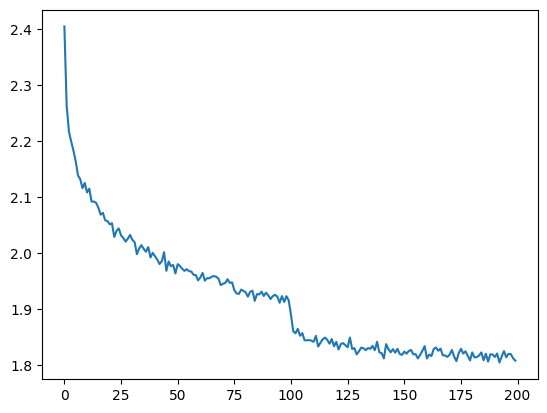

In [22]:
plt.plot(10**(torch.tensor(lossi)).view(-1, 1000).mean(1))

In [23]:
# Setting non-training mode in the BatchNorm1d layer to use the calculated mean and var 
for layer in model.layers:
    if isinstance(layer, BatchNorm1d):
        layer.training = False

In [24]:
#Calculate loss

@torch.no_grad()
def split_loss(split):
    x, y = {
        'test' : (X_test, Y_test),
        'train' : (X_train, Y_train),
        'dev' : (X_dev, Y_dev)
    }[split]
    logits = model(x)
    loss = F.cross_entropy(logits, y)
    print(f'{split} loss: {loss:.4f}')

split_loss('train')
split_loss('test')
split_loss('dev')

train loss: 1.7945
test loss: 1.9918
dev loss: 1.9921


In [25]:
# sampling from the model
for _ in range(10):
    str = ''
    idx = [0] * block_size
    while True:
        logits = model(torch.tensor([idx]))
        probs = F.softmax(logits, dim=1)
        new_idx = torch.multinomial(probs, num_samples=1).item()
        if new_idx == 0:
            break;
        str += itos[new_idx]
        idx = idx[1:] + [new_idx]
    print(str)
    

jebezuly
xaylian
eladora
amya
wrint
devente
marston
bryndt
charleigh
hermoni
